In [51]:
import sys
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from mike_config import TFrame, crypto_lst, time_frame

sys.path.append(r"D:\GitHub\tryStock\model\util")
import plot_utils
from plot_utils import one_hot, plot_curve

In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # wx+b
        self.fc1 = nn.Linear(160, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 4)

    def forward(self, x):
        # x: [28 * 28]
        x = x.float()

        # h1 = relu(w1x+b1)
        x = F.relu(self.fc1(x))
        # h2 = relu(w2h1+b2)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)

        return x

In [53]:
INPUT_LEN = 160

In [54]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

def load_dataset(symbol: str, time_frame: str, batch_size=512):
    file_path = 'D:/GitHub/tryStock/data/' + symbol.replace("/", "") + '/' + time_frame + '/featured.csv'
    df = pd.read_csv(file_path)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_inputs = torch.tensor(train_df.iloc[:, :INPUT_LEN].values)
    train_outputs = torch.tensor(train_df.iloc[:, -1].values)
    test_inputs = torch.tensor(test_df.iloc[:, :INPUT_LEN].values)
    test_outputs = torch.tensor(test_df.iloc[:, -1].values)

    train_loader = DataLoader(TensorDataset(train_inputs, train_outputs), batch_size=batch_size,  shuffle=True)
    test_loader = DataLoader(TensorDataset(test_inputs, test_outputs), batch_size=batch_size,  shuffle=True)
    return train_loader, test_loader


In [55]:
train_loader, test_loader = load_dataset(crypto_lst[0], time_frame[0].name, 512)

Epoch: 0, 0, Loss: 0.3766619563102722, LR: [0.0005]
Epoch: 0, 10, Loss: 0.33125460147857666, LR: [0.0005]
Epoch: 0, 20, Loss: 0.26841259002685547, LR: [0.0005]
Epoch: 0, 30, Loss: 0.2254301905632019, LR: [0.0005]
Epoch: 0, 40, Loss: 0.200284942984581, LR: [0.0005]
Epoch: 0, 50, Loss: 0.2021729201078415, LR: [0.0005]
Epoch: 0, 60, Loss: 0.1837078481912613, LR: [0.0005]
Epoch: 0, 70, Loss: 0.17916084825992584, LR: [0.0005]
Epoch: 0, 80, Loss: 0.18107643723487854, LR: [0.0005]
Epoch: 0, 90, Loss: 0.17782118916511536, LR: [0.0005]
Epoch: 0, 100, Loss: 0.17705008387565613, LR: [0.0005]
Epoch: 0, 110, Loss: 0.18021024763584137, LR: [0.0005]
Epoch: 0, 120, Loss: 0.170337975025177, LR: [0.0005]
Epoch: 0, 130, Loss: 0.16365575790405273, LR: [0.0005]
Epoch: 0, 140, Loss: 0.1757386028766632, LR: [0.0005]
Epoch: 0, 150, Loss: 0.1651238650083542, LR: [0.0005]
Epoch: 0, 160, Loss: 0.1732909232378006, LR: [0.0005]
Epoch: 0, 170, Loss: 0.1691456139087677, LR: [0.0005]
Epoch: 0, 180, Loss: 0.1715807318

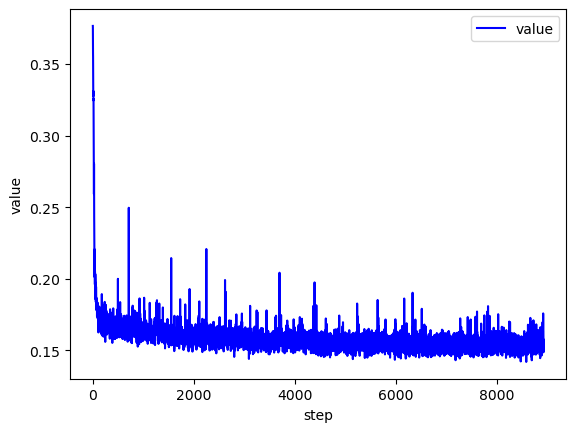

In [68]:
from torch.nn.functional import normalize
from torch.optim import lr_scheduler

net = Net()
def train(net, num_epoch, train_loader):
    # [w1, b1, w2, b2, w3, b3]
    opt = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)
    scheduler = lr_scheduler.StepLR(opt, step_size=1500, gamma=0.5)
    train_loss = []
    for epoch in range(num_epoch):
        for batch_idx, (value, label) in enumerate(train_loader):
            value = value.view(value.size(0), INPUT_LEN)
            out = net(value)
            norm_out = normalize(out, p=2.0, dim=1)
            scaled_tensor = (norm_out - norm_out.min()) / (norm_out.max() - norm_out.min())
            label_onehot = one_hot(label, 4)
            # print(label_onehot)
            # print(scaled_tensor)
            # loss = mse(out, label_onehot)
            loss = F.mse_loss(scaled_tensor, label_onehot)
            # print(loss.item())

            loss.backward()
            # w' = w - lr*grad
            opt.step()
            opt.zero_grad()
            scheduler.step()

            train_loss.append(loss.item())

            if batch_idx % 10 == 0:
                print(f"Epoch: {epoch}, {batch_idx}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()}")
    plot_curve(train_loss)
train(net, 10, train_loader)

In [71]:
import numpy as np
from sklearn.metrics import confusion_matrix

def test(net, test_loader):
    total_correct = [0, 0, 0, 0]
    total_count = [0, 0, 0, 0]
    true_labels = np.array([])
    predicted_labels = np.array([])
    for value, label in test_loader:
        value = value.view(value.size(0), INPUT_LEN)
        out = net(value)
        norm_out = normalize(out, p=2.0, dim=1)
        scaled_tensor = (norm_out - norm_out.min()) / (norm_out.max() - norm_out.min())
        pred = scaled_tensor.argmax(dim=1)
        temp = pred.eq(label) #.sum().float()

        print(confusion_matrix(label.numpy(), pred.numpy()))

        true_labels = np.append(true_labels, label.numpy())
        predicted_labels = np.append(predicted_labels, pred.numpy())


    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    print(f"confusion matrix: \n{confusion_mat}")
test(net, test_loader)

[[  1  41   2   0]
 [  4 149  64   3]
 [  0  58 125   1]
 [  0  56   7   1]]
[[  1  38   3   0]
 [  4 146  70   5]
 [  0  72 116   1]
 [  3  40  12   1]]
[[  4  42   4   2]
 [  6 158  71   6]
 [  0  52 107   0]
 [  2  47   9   2]]
[[  5  48   4   2]
 [  2 147  67   4]
 [  0  69 110   0]
 [  0  40  12   2]]
[[  5  33   6   1]
 [  6 137  72   8]
 [  0  54 121   2]
 [  3  44  17   3]]
[[  4  35   1   3]
 [  4 163  62   2]
 [  0  62 105   0]
 [  2  55  12   2]]
[[  5  40   2   2]
 [  7 154  67   2]
 [  0  73 110   0]
 [  2  33  15   0]]
[[  5  41   4   2]
 [  2 139  73   2]
 [  0  69 111   1]
 [  0  48  15   0]]
[[  3  51   3   4]
 [  5 147  70   3]
 [  0  63 106   1]
 [  3  41   9   3]]
[[  1  32   1   4]
 [  2 145  73   2]
 [  0  60 125   0]
 [  1  45  19   2]]
[[  5  36   5   0]
 [  6 152  83   3]
 [  0  49 124   2]
 [  1  31  13   2]]
[[  4  34   0   4]
 [  1 162  65   1]
 [  1  57 118   0]
 [  1  53  11   0]]
[[  5  35   4   1]
 [  2 179  60   3]
 [  0  69 104   0]
 [  2  38   8   2]]

# Summary

Doing **very bad**, but reasonable. Linear Regression (SGD) is good at T/F question not classification.
Besides the data itself is not balanced, which result in poor ability in predicting minority classes.

## Design

I have tried Linear model with 3, 6 and 11 layers.

I finally select 6 layers for no reason.

They all perform like shit, so I did not do much analysis on them

The 3 layers results in 53% accuracy, but I did not draw confusion matrix for it.
The 11 layers results in 44% accuracy which is even more over-fitting
The 6 layers model's result is shown above, it is compare good at predicting class 1 and 2, but not 0 and 3 (minority).

## Training

I have tried many LR and Momentum, and finally select LR=0.005 and Momentum=0.9 base on experience.
Every 1500 steps, The LR will decrease by 50% to keep the Loss constant dropping.

In the end, the Training loss vary between 15% and 16%, which is good. But the testing result shows over-fitting.

I will add validation set to avoid such problem in next model.